<a href="https://colab.research.google.com/github/hchaparov/Dynamic_Pricing_MARL/blob/main/2A_Connect4_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3
!pip install 'kaggle-environments'

In [2]:
import gymnasium as gym
import os
import sys
import inspect
import numpy as np

import torch as th
import torch.nn as nn
th.set_printoptions(profile="full")

from tqdm.auto import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.monitor import Monitor, load_results
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from kaggle_environments import evaluate, make, utils

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
LOG_DIR = "/content/drive/MyDrive/connect4/logs_100k/"
os.makedirs(LOG_DIR, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class Connect4(gym.Env):

    def __init__(self, opponent = 'random', switch_prob = 0.5):
        self.env = make('connectx', debug = False)
        self.switch_prob = switch_prob
        self.agents = [None, opponent] # The agent will train in place of None
        self.trainer = self.env.train(self.agents)
        config = self.env.configuration
        # PyTorch Conv2d expect 4 dimensional data
        # (nSamples x nChannels x Height x Width)
        self.board_template = (1, config.rows, config.columns)
        self.board = np.zeros(self.board_template, int)

        # Define required gym fields
        self.reward_range = (-1, 0, 1) # lose: -1, draw: 0, win: 1
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Box(
            # ``low`` and ``high`` represent the possible values
            low = 0,
            high = 2,
            shape = self.board_template,
            dtype = int
        )

    def switch_starting_positions(self):
        self.agents = self.agents[::-1]
        self.trainer = self.env.train(self.agents)

    def step(self, action):
        # Check for invalid moves
        if self.board[0][0][int(action)] != 0:
            reward, done, info = -10, True, {}
            observation = self.board
        else:
            observation, reward, done, info = self.trainer.step(int(action))
            self.board = np.array(observation['board']).reshape(self.board_template)

        terminated = done
        truncated = False  # Truncation condition is not specified

        return self.board, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)

        if np.random.random() < self.switch_prob:
            self.switch_starting_positions()

        self.board = np.array(
            self.trainer.reset()['board']
        ).reshape(self.board_template)

        # Return the observation and an empty info dictionary
        return self.board, {}


training_env = Connect4('random')

# Add logging
training_env = Monitor(training_env, LOG_DIR, allow_early_resets = True)

# Vectorize environment (expected by stable-baselines3 algorithms)
training_env = DummyVecEnv([lambda: training_env])

In [5]:
MODEL_PATH = '/content/drive/MyDrive/connect4/ppo_model_100k'

# Load or initialize agent
if os.path.exists(MODEL_PATH + '.zip'):
    print('Loading existing model\n')
    agent_ppo = PPO.load(
        path = MODEL_PATH,
        env = training_env,
        verbose = 1
    )
else:
    print('Creating a new model\n')
    agent_ppo = PPO(
        policy = 'MlpPolicy',
        env = training_env,
        learning_rate=3e-4,  # Lower learning rate for stable training
        n_steps=2048,        # Increase number of steps per update
        batch_size=64,       # Batch size for each update
        n_epochs=10,         # Number of epochs to optimize the surrogate loss
        gamma=0.99,          # Discount factor
        gae_lambda=0.95,     # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        clip_range=0.2,      # Clipping parameter
        ent_coef=0.01,       # Coefficient for entropy
        vf_coef=0.5,         # Coefficient for value function loss
        max_grad_norm=0.5,   # Maximum norm for gradient clipping
        verbose=1
    )


print(agent_ppo.policy)

Creating a new model

Using cpu device
ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=42, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=42, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=7, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.3     |
|    ep_rew_mean     | -2.77    |
| time/              |          |
|    fps             | 57       |
|    iterations      | 1        |
|    time_elapsed    | 35       |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=4096, episode_reward=0.02 +/- 2.23
Episode length: 9.13 +/- 2.95
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 9.13        |
|    mean_reward          | 0.02        |
| time/                   |             |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008533621 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.0364     |
|    learning_rate        | 0.0003      |
|    loss                 | 5.

<Axes: >

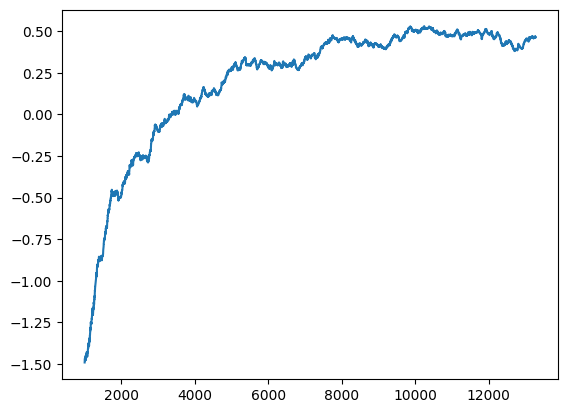

In [6]:
TOTAL_TIMESTEPS = 100_000
EVAL_FREQ = 4096 # The policy is updated every 2048 timesteps
EVAL_EPISODES = 100 # How many episodes the agent should be tested for evaluation


agent_ppo.learn(
        total_timesteps = TOTAL_TIMESTEPS,
        callback = [
            EvalCallback(
                eval_env = training_env,
                n_eval_episodes = EVAL_EPISODES,
                best_model_save_path = LOG_DIR,
                log_path = LOG_DIR,
                eval_freq = EVAL_FREQ,
                deterministic = True,
                render = False
            )
        ]
    )
agent_ppo.save('/content/drive/MyDrive/connect4/ppo_model_100k')

# Display training result
df = load_results(LOG_DIR)['r']
df.rolling(window = 1000).mean().plot()

In [7]:
def ppo_agent(observation, config = {'rows': 6, 'columns': 7, 'inarow': 4}):
  observation = np.array(observation['board']).reshape(1, config['rows'], config['columns'])
  action, info = agent_ppo.predict(observation)

  return int(action)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [9]:
# Create the game environment
env = make("connectx", debug=True)

env.run([ppo_agent, ppo_agent])

# To render using iPython, we have to use a notebook as the Kaggle editor can't show HTML objects
env.render(mode="ipython", width=500, height=450)


get_win_percentages(agent1=ppo_agent, agent2='random')
print('\n')
get_win_percentages(agent1=ppo_agent, agent2='negamax')
print('\n')
get_win_percentages(agent1=ppo_agent, agent2=ppo_agent)


Agent 1 Win Percentage: 0.8
Agent 2 Win Percentage: 0.2
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


Agent 1 Win Percentage: 0.05
Agent 2 Win Percentage: 0.92
Number of Invalid Plays by Agent 1: 2
Number of Invalid Plays by Agent 2: 0


Agent 1 Win Percentage: 0.49
Agent 2 Win Percentage: 0.46
Number of Invalid Plays by Agent 1: 3
Number of Invalid Plays by Agent 2: 2


In [10]:
# Create the game environment
env = make("connectx", debug=True)

env.run(['negamax', 'random'])

# To render using iPython, we have to use a notebook as the Kaggle editor can't show HTML objects
env.render(mode="ipython", width=500, height=450)


get_win_percentages(agent1='negamax', agent2='random')

Agent 1 Win Percentage: 0.98
Agent 2 Win Percentage: 0.02
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
